### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

fatal: destination path 'cv_project' already exists and is not an empty directory.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=5a2a5d3c8e2f7c76e3a001276fc691d5e2ea97ff7e428a0f3f233f8ee4337c04
  Stored in directory: /tmp/pip-ephem-wheel-cache-48e81q4c/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src
  Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

In [6]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Aerial-Cars-Dataset
# ResNet50
# Pipeline: Norm

### Load dataset

In [7]:
DATA_PATH = DRIVE_PATH+'data/processed/aerial-cars-dataset/resnet/data_resnet.pickle'

In [8]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [9]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [10]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

Epoch 1/5
43/43 [==============================] - 13s 92ms/step - loss: 0.3743 - accuracy: 0.8995 - val_loss: 0.0941 - val_accuracy: 0.9873
Epoch 2/5
43/43 [==============================] - 2s 48ms/step - loss: 0.0341 - accuracy: 0.9909 - val_loss: 0.0554 - val_accuracy: 0.9979
Epoch 3/5
43/43 [==============================] - 2s 48ms/step - loss: 0.0138 - accuracy: 0.9965 - val_loss: 0.0426 - val_accuracy: 0.9936
Epoch 4/5
43/43 [==============================] - 2s 47ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0463 - val_accuracy: 0.9936
Epoch 5/5
43/43 [==============================] - 2s 48ms/step - loss: 3.2996e-04 - accuracy: 1.0000 - val_loss: 0.0479 - val_accuracy: 0.9936


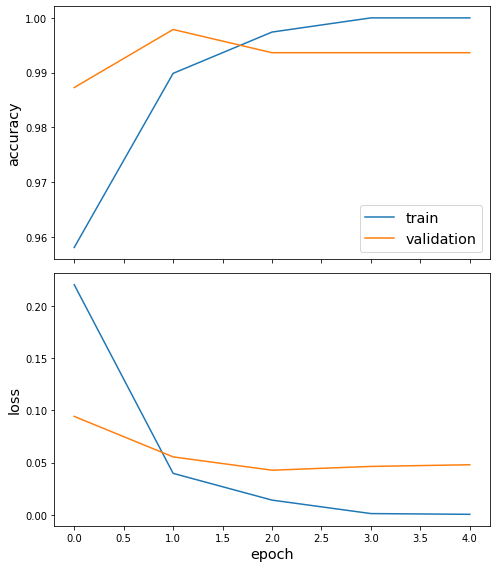

In [11]:
plot_history(history)

### Validation

In [12]:
data = None

In [13]:
BND_BOX_SIZE = (80, 80)
STEP_SIZE = 20

dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.7; nms_overlap=0.4


In [15]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.7,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/aerial-cars-dataset/norm/t7nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:06<00:52,  6.59s/it]

192


 22%|██▏       | 2/9 [00:11<00:41,  6.00s/it]

251


 33%|███▎      | 3/9 [00:15<00:33,  5.60s/it]

57


 44%|████▍     | 4/9 [00:20<00:26,  5.31s/it]

54


 56%|█████▌    | 5/9 [00:25<00:20,  5.12s/it]

258
129


 78%|███████▊  | 7/9 [00:55<00:18,  9.40s/it]

241


 89%|████████▉ | 8/9 [01:00<00:08,  8.01s/it]

197


100%|██████████| 9/9 [01:05<00:00,  7.28s/it]

174



Precision: 0.254
Recall: 0.903
F1Score: 0.397


treshold = 0.8; nms_overlap=0.4

In [15]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.8,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/aerial-cars-dataset/norm/t8nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:06<00:48,  6.10s/it]

211


 22%|██▏       | 2/9 [00:10<00:39,  5.66s/it]

245


 33%|███▎      | 3/9 [00:15<00:32,  5.34s/it]

56


 44%|████▍     | 4/9 [00:19<00:25,  5.12s/it]

53


 56%|█████▌    | 5/9 [00:24<00:19,  4.98s/it]

266
137


 78%|███████▊  | 7/9 [00:55<00:18,  9.42s/it]

245


 89%|████████▉ | 8/9 [01:00<00:08,  8.03s/it]

211


100%|██████████| 9/9 [01:05<00:00,  7.26s/it]

181



Precision: 0.235
Recall: 0.867
F1Score: 0.37


treshold = 0.9; nms_overlap=0.4

In [16]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/aerial-cars-dataset/norm/t9nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:04<00:38,  4.84s/it]

201


 22%|██▏       | 2/9 [00:09<00:33,  4.82s/it]

232


 33%|███▎      | 3/9 [00:14<00:28,  4.79s/it]

48


 44%|████▍     | 4/9 [00:19<00:23,  4.77s/it]

48


 56%|█████▌    | 5/9 [00:23<00:19,  4.76s/it]

253


 67%|██████▋   | 6/9 [00:45<00:29,  9.89s/it]

118


 78%|███████▊  | 7/9 [00:50<00:16,  8.35s/it]

233


 89%|████████▉ | 8/9 [00:55<00:07,  7.31s/it]

194


100%|██████████| 9/9 [01:00<00:00,  6.68s/it]

168



Precision: 0.275
Recall: 0.912
F1Score: 0.423


treshold = 0.95; nms_overlap=0.4

In [17]:
processed_images = None

slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.95,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/aerial-cars-dataset/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/aerial-cars-dataset/norm/t95nms4',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)


print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

 11%|█         | 1/9 [00:04<00:38,  4.85s/it]

190


 22%|██▏       | 2/9 [00:09<00:33,  4.82s/it]

212


 33%|███▎      | 3/9 [00:14<00:28,  4.81s/it]

48


 44%|████▍     | 4/9 [00:19<00:24,  4.80s/it]

46


 56%|█████▌    | 5/9 [00:23<00:19,  4.80s/it]

247


 67%|██████▋   | 6/9 [00:45<00:29,  9.71s/it]

107


 78%|███████▊  | 7/9 [00:49<00:16,  8.23s/it]

228


 89%|████████▉ | 8/9 [00:54<00:07,  7.19s/it]

179


100%|██████████| 9/9 [00:59<00:00,  6.60s/it]

155



Precision: 0.277
Recall: 0.85
F1Score: 0.418
